# Advanced Lane Lines Detection


# Problem

Given a set of images taken from a camera mounted on top of the car we have to identify the left and right lines of the lane on the road and calculate the radius of curvature. 


# Proposed Method  

First we compute the camera calibration matrix and distortion coefficients given a set of chessboard images (in the camera_cal folder in the repository).

Next, for a series of test images (in the test_images folder in the repository):

1. Apply the distortion correction to the raw image.
2. Use color transforms, gradients, etc., to create a thresholded binary image.
3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Detect lane pixels and fit to find lane boundary.
5. Determine curvature of the lane and vehicle position with respect to center.
6. Warp the detected lane boundaries back onto the original image.
7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
8. Once you have implemented a successful pipeline on the test images, you will run your algorithm on a video. In the case of the video, you must search for the lane lines in the first few frames, and, once you have a high-confidence detection, use that information to track the position and curvature of the lines from frame to frame.
9. Check out the project rubric before you submit to make sure your project is complete!.

In [1]:
# Import everything needed to edit/save/watch video clips

from IPython.display import HTML
from moviepy.editor import VideoFileClip

In [2]:
# import libs
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import copy

# import functions from other files
from camera_calibration import calibrate_camera
from image_transformation import warp
from image_transformation import plotImageSet
from image_transformation import region_of_interest
from image_transformation import get_peak
from image_transformation import weighted_img

# Helper functions

In [3]:
# warp a lane shape from the perspective to the orthogonal view
# in fact we want to use it to do the inverse transformation
def warp_lane(img,direction=0):
    if len(img.shape)>2:
        height, width, channels = img.shape
    else:
        height, width = img.shape
        
    # compute the perspective transform M
#     src_point_1 = (round(0.22*width),round(0.95*height))
#     src_point_2 = (round(width*0.45),round(0.65*height))
#     src_point_3 = (round(width*0.58),round(0.65*height))
#     src_point_4 = (round(width*0.87), round(0.95*height))
    src_point_1 = (round(0.16*width),round(0.95*height))
    src_point_2 = (round(width*0.425),round(0.65*height))
    src_point_3 = (round(width*0.58),round(0.65*height))
    src_point_4 = (round(width*0.855), round(0.95*height))

    dst_point_1 = (round(0.2*width),height)
    dst_point_2 = (round(0.2*width),round(0.2*height))
    dst_point_3 = (round(0.85*width),round(0.2*height))
    dst_point_4 = (round(0.85*width),height)

    #four source and destination coordinates
    src = np.float32([src_point_1,src_point_2,src_point_3,src_point_4])
    dst = np.float32([dst_point_1,dst_point_2,dst_point_3,dst_point_4])

    warped_img = warp(img,src,dst,direction)
    return warped_img

In [4]:
# check and draw warping area of the image
def draw_wrap_area(img,color = (100,0,0)):
    height, width, channels = img.shape
    src_point_1 = (round(0.16*width),round(0.95*height))
    src_point_2 = (round(width*0.425),round(0.65*height))
    src_point_3 = (round(width*0.58),round(0.65*height))
    src_point_4 = (round(width*0.855), round(0.95*height))
    img_wrap_area = copy.copy(img)
    cv2.line(img_wrap_area, src_point_1, src_point_2, color, thickness=2)
    cv2.line(img_wrap_area, src_point_2, src_point_3, color, thickness=2)
    cv2.line(img_wrap_area, src_point_3, src_point_4, color, thickness=2)
    cv2.line(img_wrap_area, src_point_4, src_point_1, color, thickness=2)
    return img_wrap_area

In [5]:
# get list of pixels (x,y coord) for each line:
def get_pixel_lists(im, left_color, right_color):
    left_line_x = []
    left_line_y = []

    right_line_x = []
    right_line_y = []

    height,width,channels = im.shape
    for i in range(height):
         for j in range(width):   
            red_val = im[i,j,0] 
            green_val = im[i,j,1]
            blue_val = im[i,j,2]
            if (red_val == left_color[0] and green_val==left_color[1] and blue_val==left_color[2]): 
                left_line_y.append(i)
                left_line_x.append(j)
            if (red_val == right_color[0] and green_val==right_color[1] and blue_val==right_color[2]): 
                right_line_y.append(i)
                right_line_x.append(j)

    left_line_y = np.array(left_line_y)
    left_line_x = np.array(left_line_x)
    right_line_y = np.array(right_line_y)
    right_line_x = np.array(right_line_x)
    return left_line_x,left_line_y,right_line_x,right_line_y


In [6]:
# fit a 2nd order polynomial to the x and y values
def fit_polynom(x_values, y_values):
    pol_fit = np.polyfit(y_values, x_values, 2)
    pol_fitx = pol_fit[0]*y_values**2 + pol_fit[1]*y_values + pol_fit[2]
    return pol_fitx,pol_fit

In [7]:
# retrieves the curvature radius (in meters) from the set of points
def get_curvature_radius(x_values,y_values):
    y_eval = np.max(y_values)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr  = np.polyfit(y_values*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                             /np.absolute(2*fit_cr[0])
    return curverad

In [8]:
# 6. Warp the detected lane boundaries back onto the original image.
# computes the output value given the input value and the 2nd order function (coeficients)
def get_out_value(input, function):
    output = function[0]*input**2 + function[1]*input + function[2]
    return output

In [62]:
# draw the lane given the edge points of the function
def draw_lane(img,left_fit,right_fit,start_y=0,end_y=0,color=(0,255,0)):
    
    if end_y==0:
        end_y = img.shape[0]
    #draw line from left to right
    for y_val in range(start_y,end_y):
        pt1 = (int(get_out_value(y_val, left_fit)),y_val)
        pt2 = (int(get_out_value(y_val, right_fit)),y_val)
        cv2.line(img,pt1,pt2,color)
    return img

In [77]:
# 4. Detect lane pixels in birds-eye image
# note img_channel should have values ranging from 0 to 1
def identify_lines( img_channel, left_color, right_color, 
                   left_search_point=0, 
                   left_amplitude=0,
                   right_search_point=0, 
                   right_amplitude=0,
                   debug=0):
    
    original_height, original_width = img_channel.shape
    
    if left_search_point==0 and right_search_point==0:
        left_search_point = round(original_width/4)
        right_search_point = round(3*original_width/4)
        left_amplitude = round(original_width/4)
        right_amplitude = round(original_width/4)

    step_height = round(original_height/2)

    if debug:
        line_img = copy.copy(img_channel)
    
    left_mask = np.zeros_like(img_channel)
    right_mask = np.zeros_like(img_channel)
    
    num_steps = 10
    for i in range(num_steps):

        img_fraction = img_channel[(original_height-step_height*(i+1)):(original_height-step_height*(i)),
                                   0:original_width]
        height, width = img_fraction.shape

        lx1=(left_search_point-left_amplitude)
        lx2=(left_search_point+left_amplitude)
        ly1=(original_height-step_height*(i+1))
        ly2=(original_height-step_height*(i))    

        # validate x1, x2
        lx1 = max(lx1,0)
        lx1 = min(lx1,original_width)
        lx2 = max(lx2,0)
        lx2 = min(lx2,original_width)
        
        region_left  = img_fraction[0:height,lx1:lx2]
        
        #(img, (x1, y1), (x2, y2), color, thickness)
        if debug:
            cv2.rectangle(line_img, (lx1, ly1), (lx2, ly2), (1,1,0), 2)
        
        left_peak_x = lx1 + get_peak(region_left,threshold=0.5,min_pixels=3)

        rx1=(right_search_point-right_amplitude)
        rx2=(right_search_point+right_amplitude)
        ry1=(original_height-step_height*(i+1))
        ry2=(original_height-step_height*(i))

        # validate x1, x2
        rx1 = max(rx1,0)
        rx1 = min(rx1,original_width)
        rx2 = max(rx2,0)
        rx2 = min(rx2,original_width)
        
        region_right = img_fraction[0:height,rx1:rx2]
        
        if debug:
            cv2.rectangle(line_img, (rx1, ry1), (rx2, ry2), (1,1,0), 2)
            
        right_peak_x = rx1 + get_peak(region_right,threshold=0.5,min_pixels=3)

        left_search_point = left_peak_x
        right_search_point = right_peak_x
        left_amplitude = 100
        right_amplitude = 100
        
        if i==1:
            left_sp = left_search_point
            left_amp = left_amplitude
            right_sp = right_search_point
            right_amp = right_amplitude
        
        step_height = round(original_height/num_steps)

        color_lx1 = left_search_point-left_amplitude/2;
        color_lx2 = left_search_point+left_amplitude/2;
        color_rx1 = right_search_point-right_amplitude/2;
        color_rx2 = right_search_point+right_amplitude/2;
        # validate
        color_lx1 = max(0,color_lx1)
        color_lx1 = min(original_width,color_lx1)
        color_lx2 = max(0,color_lx2)
        color_lx2 = min(original_width,color_lx2)
        color_rx1 = max(0,color_rx1)
        color_rx1 = min(original_width,color_rx1)
        color_rx2 = max(0,color_rx2)
        color_rx2 = min(original_width,color_rx2)
        
        #color pixels on the left and on the right
        left_mask[(original_height-step_height*(i+1)):(original_height-step_height*(i)),color_lx1:color_lx2] = 1
        right_mask[(original_height-step_height*(i+1)):(original_height-step_height*(i)),color_rx1:color_rx2] = 1
        
        if debug:
            mpimg.imsave('report/id_lines_'+str(i)+'.png',line_img,cmap='gray')
            
    if debug:
        plt.imshow(line_img,'gray')

    r_channel = copy.copy(img_channel)
    g_channel = copy.copy(img_channel)
    b_channel = copy.copy(img_channel)
    im = np.dstack((r_channel, g_channel, b_channel))
    
    im[(img_channel >= 0.5) & (left_mask >= 0.5)] = left_color
    im[(img_channel >= 0.5) & (right_mask >= 0.5)] = right_color
    
    return im, left_sp, left_amp, right_sp, right_amp

In [64]:
def draw_line(img,fit_func,color=(255,255,255), thickness=24):
    height, width, channels = img.shape
    pixels = []
    # get the pixels to color
    for y_val in range(height):
        x_val = get_out_value(y_val,fit_func)
        pixels.append([y_val,x_val])
    # color the pixels
    for pixel in pixels:
        for i in range(thickness):
            # check if pixel within range
            index = int(pixel[1]-thickness/2+i)
            if index>0 and index<width:
                img[pixel[0]][index]=color
        
    return img

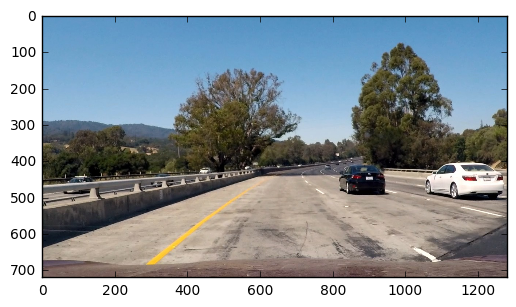

In [65]:
# test draw_line()
afile="test1.jpg"
filename = 'test_images/'+afile
img = mpimg.imread(filename)
fit_func = [0,-10,0]
img2 = draw_line(img,fit_func)
plt.imshow(img2)
plt.show()


In [13]:
def plot_fit_lines(left_line_x, left_line_y, right_line_x, right_line_y, left_fitx, right_fitx):
    plt.plot(left_line_x, left_line_y, 'o', color='red')
    plt.plot(right_line_x, right_line_y, 'o', color='blue')
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fitx, left_line_y, color='green', linewidth=3)
    plt.plot(right_fitx, right_line_y, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images

# Camera Calibration

In [14]:
# 0. Calibrate the camera using the calibration images
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y
mtx,dist = calibrate_camera('camera_cal/calibration*.jpg',nx, ny)

Calibrating camera... please be patient!
Camera calibrated using  17  out of  20  images!


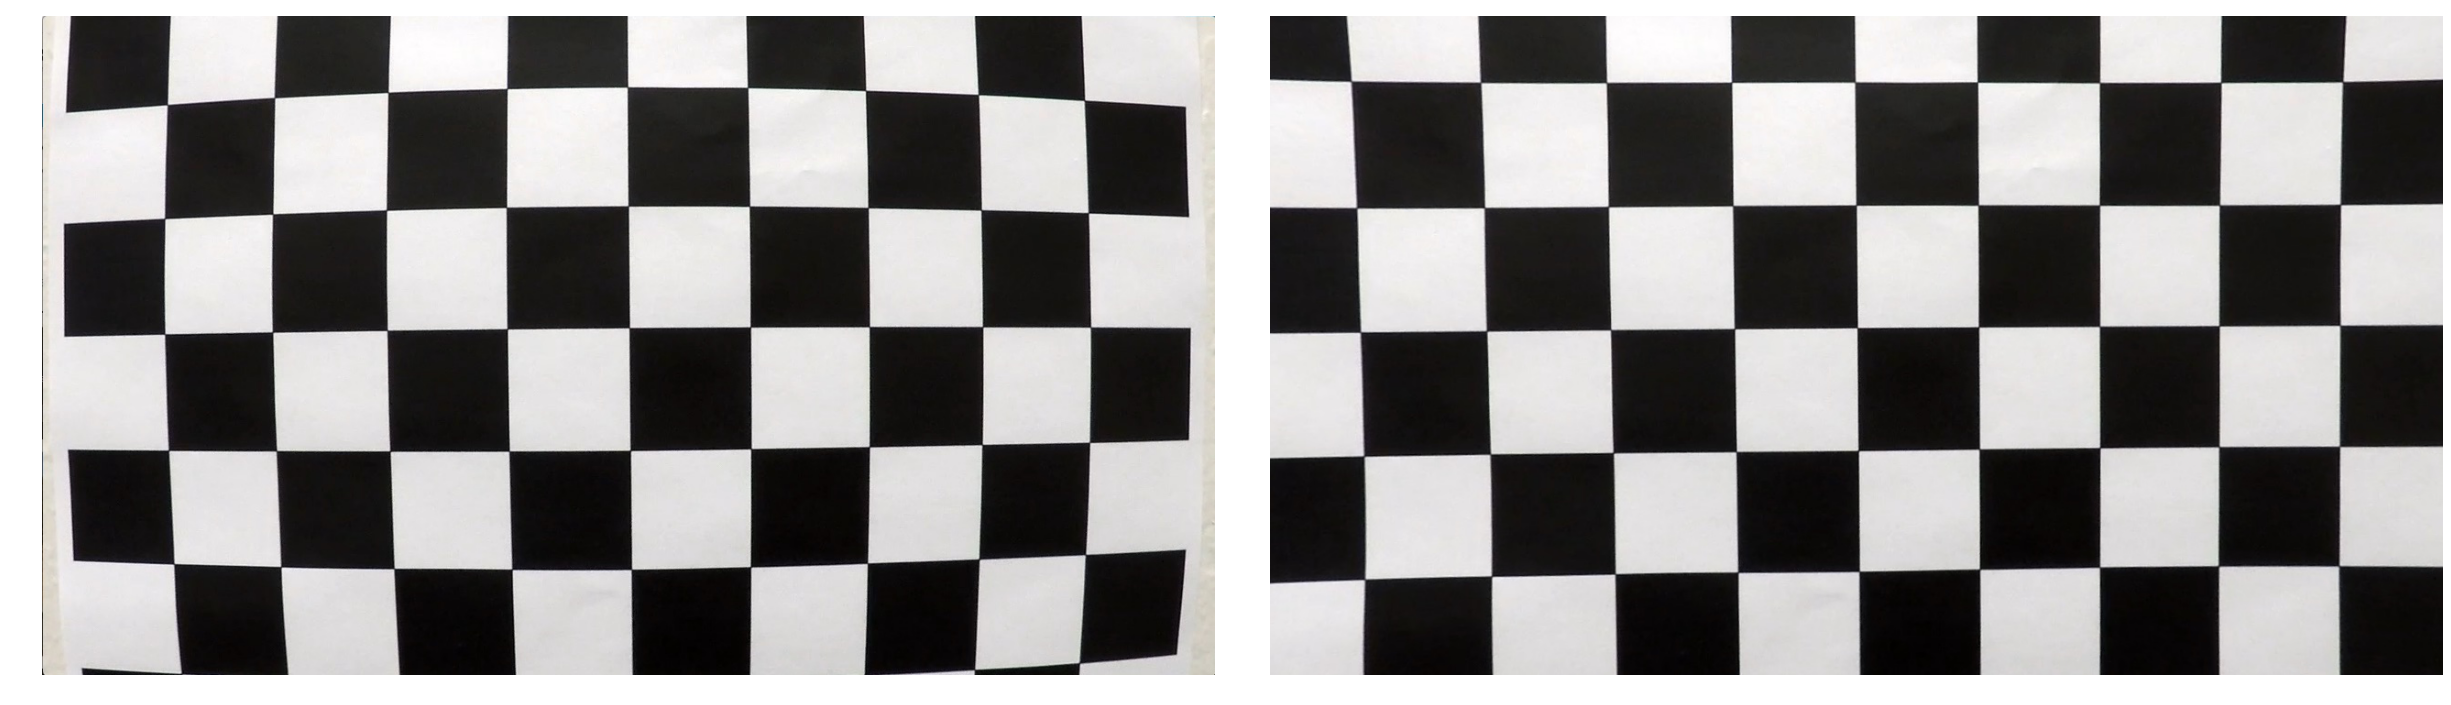

In [15]:
# 1 .Apply distortion correction to the raw image.

# test camera calibration
fname = 'camera_cal/calibration1.jpg'
img = mpimg.imread(fname)
undistorted_im = cv2.undistort(img, mtx, dist, None, mtx)
plotImageSet([img,undistorted_im]);
mpimg.imsave('report/distorted.png',img)
mpimg.imsave('report/undistorted.png',undistorted_im)

In [72]:
# apply sobel and channel filters to enhance white and yellow lines detection

def filter_img(img, debug=0,r_thresh=(220, 255),sx_thresh=(40, 100),s_thresh=(200, 254),h_thresh=(30,40)):
        
    # break image into separate rgb channels (note values are between 0 to 1)
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    b_channel = img[:,:,2]
    
    # Convert to HLS color space and separate the S channel
#     hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
        
    #Threshold color channel r
    r_binary = np.zeros_like(g_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel hue
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Threshold color channel saturation
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    filtered_channel = np.zeros_like(g_channel)
    filtered_channel[(sxbinary >= 0.5) | (s_binary >= 0.5) | (r_binary>= 0.5)] = 255
#     filtered_channel[(sxbinary >= 0.5) | (s_binary >= 0.5) | (h_binary>= 0.5) | (r_binary>= 0.5)] = 1
    
    # h_binary captures yellow lines very well
    # sxbinary captures white lines
    # s_binary captures white and yellow lines     
    # r_binary captures yellow lines very well
    
    if debug:
        plotImageSet([h_binary,sxbinary,s_binary,r_binary,filtered_channel,])
        mpimg.imsave('report/h_binary.png',h_binary,cmap='gray')
        mpimg.imsave('report/sxbinary.png',sxbinary,cmap='gray')
        mpimg.imsave('report/s_binary.png',s_binary,cmap='gray')
        mpimg.imsave('report/r_binary.png',r_binary,cmap='gray')
        mpimg.imsave('report/filtered_channel.png',filtered_channel,cmap='gray')
#        plotImageSet([sxbinary,s_binary,r_binary,filtered_channel])

    return filtered_channel

In [67]:
def process_image(img,debug=0):
# def process_image(img, left_search_point=0,left_amplitude=0,
#                   right_search_point=0,right_amplitude=0,debug=0):
    
    if not hasattr(process_image, "count"):
        process_image.left_sp_avg = int(-100000)
        process_image.right_sp_avg = int(-100000)
        process_image.count = 0
    
    if process_image.count>3:
        left_search_point = process_image.left_sp_avg
        left_amplitude = 100
        right_search_point = process_image.right_sp_avg
        right_amplitude = 100
    else:
        left_search_point = 0
        left_amplitude = 0
        right_search_point = 0
        right_amplitude = 0
    
    if process_image.left_sp_avg>0 and process_image.right_sp_avg>0:
        process_image.count = process_image.count + 1    
    
    
    # undistort the image
    undistorted_im = cv2.undistort(img, mtx, dist, None, mtx)
    
    #filter the image
    filtered_channel = filter_img(undistorted_im,debug)

    # aplly mask to the region of interest
    # apply 1st mask to select region of interest
    height, width, channels = img.shape
    
    vertices = np.array([[(0,0.95*height),(width*0.45,0.55*height),(width*0.55, 0.55*height), (width, 0.95*height)]], dtype=np.int32);
    masked_channel = region_of_interest(filtered_channel, vertices, color_max_value=1);
    
    # warp the image to 'orthogonal bird-eyes view'
    warped_channel = warp_lane(masked_channel)
    
    # identify lines in image
    left_color = (255,0,0)
    right_color = (0,0,255)
    lines_img,left_sp, left_amp, right_sp, right_amp = identify_lines(warped_channel, left_color, right_color, 
                               left_search_point,left_amplitude,
                               right_search_point,right_amplitude,debug)
          
    # get pixel list for each line (left and righ)
    left_line_x,left_line_y,right_line_x,right_line_y = get_pixel_lists(lines_img, left_color, right_color)   
    
    # Fit a second order polynomial to each lane line
    left_fitx,left_fit = fit_polynom(left_line_x, left_line_y)
    right_fitx,right_fit = fit_polynom(right_line_x, right_line_y)
    # plot_fit_lines(left_line_x, left_line_y, right_line_x, right_line_y, left_fitx, right_fitx)
    
    fit_lines_img = np.zeros_like(lines_img)
    fit_lines_img = draw_lane(fit_lines_img,left_fit,right_fit,start_y=0,end_y=height)#round(height/5)
    fit_lines_img = draw_line(fit_lines_img,left_fit,left_color)
    fit_lines_img = draw_line(fit_lines_img,right_fit,right_color)
    
    
    # warp image back
    warped_poly = warp_lane(fit_lines_img,direction=1)
    
    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    #img, initial_img, α=0.8, β=1. Note
    processed_img = weighted_img(warped_poly,img, α=0.6, β=0.4);
    
    # Determine the vehicle position with respect to center (in meters)
    y_value = height
    x1_value = get_out_value(y_value, left_fit) 
    x2_value = get_out_value(y_value, right_fit) 
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    dist_center = ((x2_value+x1_value)/2-width/2)*xm_per_pix
    
    if not hasattr(process_image, "vehicle_pos"):
        process_image.vehicle_pos = dist_center
    else:
        process_image.vehicle_pos = 0.4 * process_image.vehicle_pos + 0.6 *dist_center 
        
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    vehicle_pos_txt = 'mid-lane dist= ' + str(round(process_image.vehicle_pos,2)) + ' m'
    # ============================================================================================= #
    txt_color = (255,255,255)
    bkg_color = (50,50,80)
    cv2.rectangle(processed_img, (0, 0), (400, 100), bkg_color, -1) # region to display info
    cv2.putText(processed_img,vehicle_pos_txt, (10,30), font, 1, txt_color)
    
    # Compute and display curvature radius in the image
    left_curverad = (get_curvature_radius(left_line_x,left_line_y))
    right_curverad = (get_curvature_radius(right_line_x,right_line_y))
    # print('left_curverad = ',left_curverad, 'm,  right_curverad =', right_curverad, 'm')

    deviation = (max(left_curverad,right_curverad)-min(left_curverad,right_curverad))/(max(left_curverad,right_curverad))
    
    if deviation > 0.5 :
        if debug:
            print("Attention: curves very different! Deviation = ",int(deviation*100)," %")
        lcurverad_txt = 'left curvature = '+str(int(round(left_curverad,-2)))+' m'
        rcurverad_txt = 'right curvature = '+str(int(round(right_curverad,-2)))+' m'
        cv2.putText(processed_img,lcurverad_txt, (10,60), font, 1, txt_color)
        cv2.putText(processed_img,rcurverad_txt, (10,90), font, 1, txt_color)
    else:
        curverad = int(round((left_curverad+right_curverad)/2))
        curverad_txt = 'curvature radius = '+str(curverad)+' m'
        cv2.putText(processed_img,curverad_txt,(10,60), font, 1, txt_color)
        
    cv2.putText(processed_img,'Nino Pereira 2016',(width-240,height-5), font, 1, txt_color)
    # update filter variables
    process_image.left_sp_avg = int(0.4 * process_image.left_sp_avg + 0.6 * left_sp)
    process_image.right_sp_avg = int(0.4 * process_image.right_sp_avg + 0.6 * right_sp)
    
    if debug:
        wrap_area = draw_wrap_area(undistorted_im) # just for debug
        plotImageSet([img, wrap_area,lines_img, fit_lines_img])
#         print(img[600:650,710:711,1])
        plotImageSet([warped_poly, masked_channel,lines_img,processed_img])
        print(left_sp, right_sp)
        print(process_image.left_sp_avg,process_image.right_sp_avg)
        print('count=',process_image.count)
        mpimg.imsave('report/original_img.png',img)
        mpimg.imsave('report/wrap_area.png',wrap_area)
        mpimg.imsave('report/undistorted_im.png',undistorted_im)
        mpimg.imsave('report/filtered_channel.png',filtered_channel,cmap='gray')
        mpimg.imsave('report/masked_channel.png',masked_channel,cmap='gray')
        mpimg.imsave('report/warped_channel.png',warped_channel,cmap='gray')
        mpimg.imsave('report/lines_img.png',lines_img)
        mpimg.imsave('report/fit_lines_img.png',fit_lines_img)
        mpimg.imsave('report/warped_poly.png',warped_poly)
        mpimg.imsave('report/processed_img.png',processed_img)
    
    return processed_img

In [79]:
# get images list
images = os.listdir("test_images/")

images = os.listdir("new_test_images/")


In [80]:
# initialise static variables
process_image.left_sp_avg = -10000
process_image.right_sp_avg = -10000
process_image.count = 0

In [53]:
# initialise static variables
process_image.left_sp_avg = 200
process_image.right_sp_avg = 1050
process_image.count = 4

# Note:  
The matplot.image library reads a png image using the imread command and gets the rgb channels converted to floats with a range from 0 to 1. if it is a jpg image then the values are from 0 to 255!  
img = mpimg.imread(filename)  

We could use instead the cv2 library, which reads files into a bgr format between 0 and 255 regardless if it is a png or a jpg file:  
img = cv2.imread(filename) # reads a file into bgr values 0-255  
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb  
plt.imshow(img)  

At the moment all the functions work with the first method. If you want to use the 2nd method for any reason, be sure to modify the functions, namely the filter_img function.

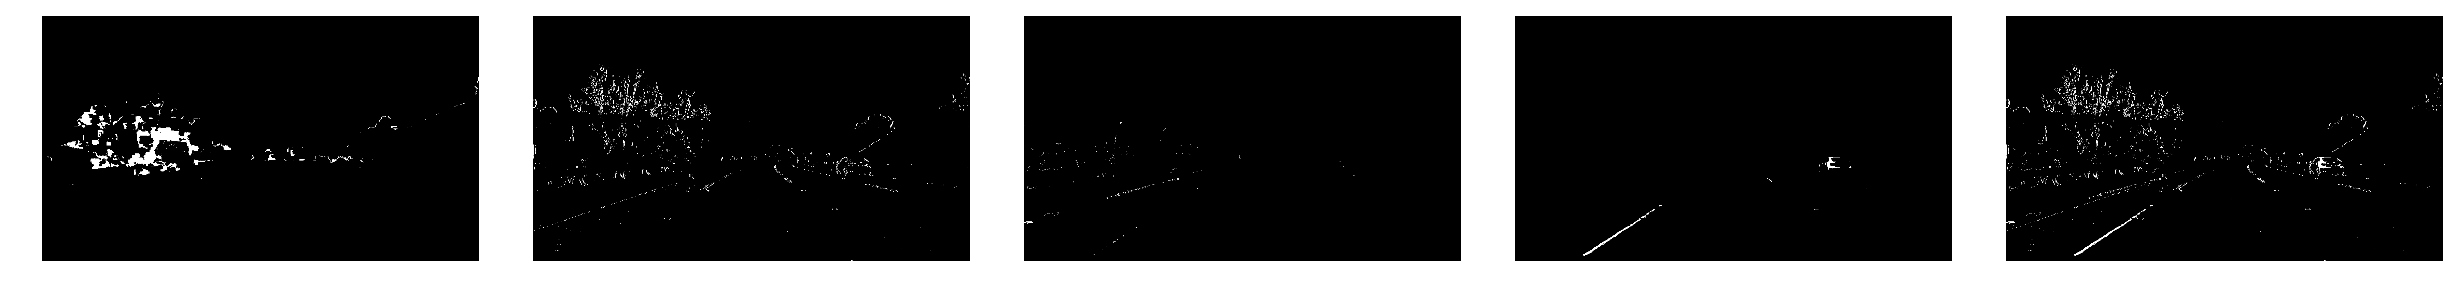

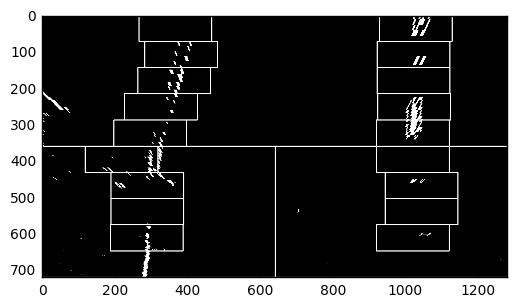

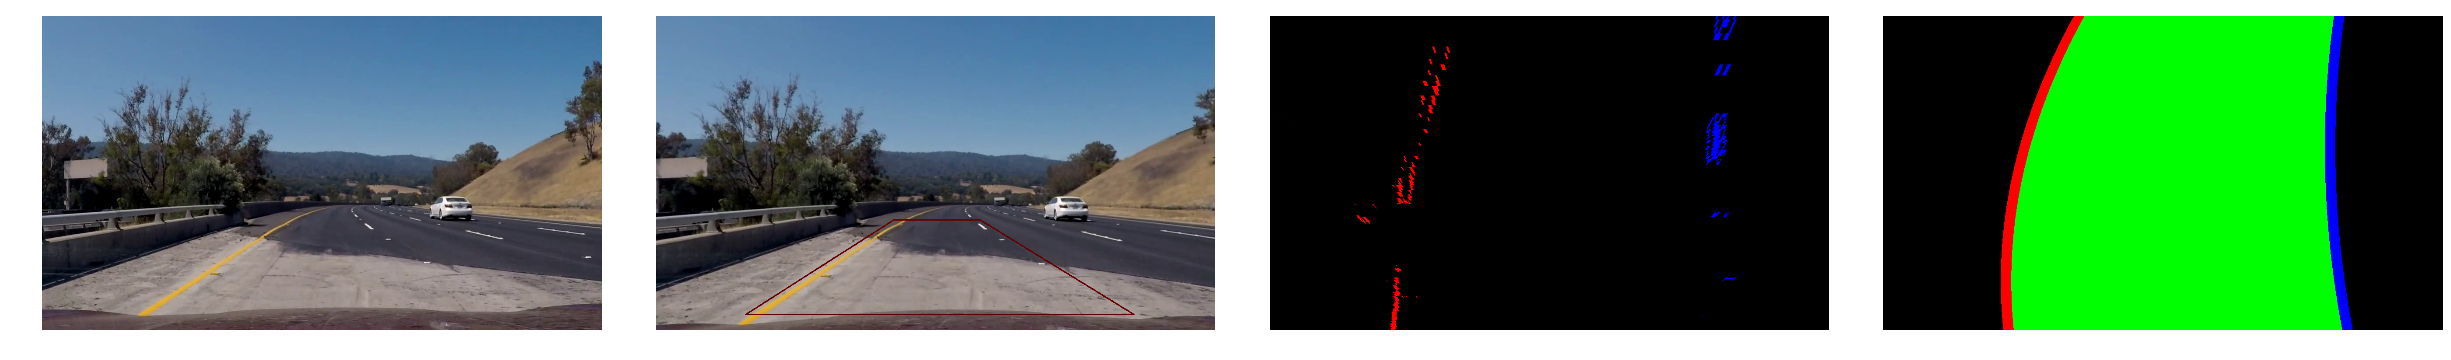

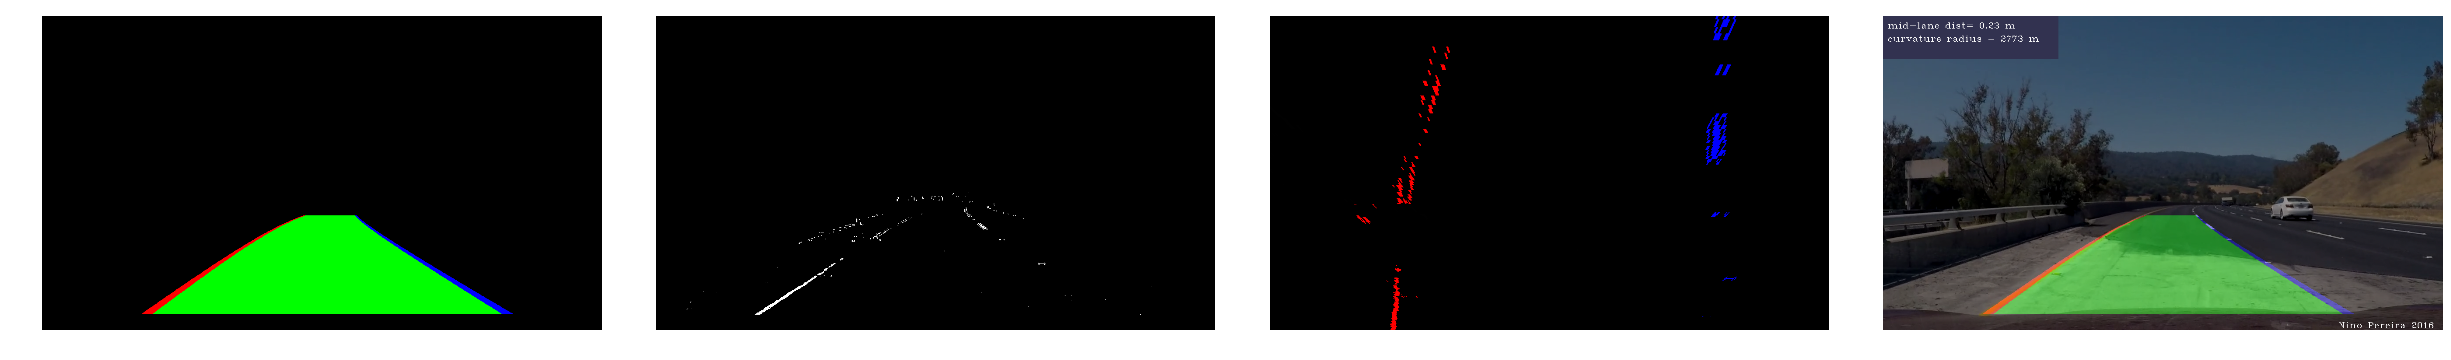

289 1042
37 765
count= 0


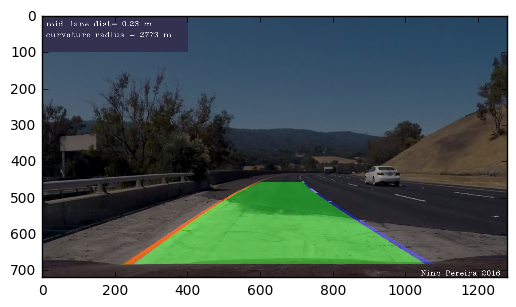

Finished processing image


In [86]:
#test filter_image
afile= "test11.png"
# afile= "test1.jpg"
# afile= "solidWhiteRight.jpg"
filename = 'new_test_images/'+afile 
img = cv2.imread(filename) # reads a file into bgr values 0-255  
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # inverts bgr to rgb

#img = mpimg.imread(filename) # reads to RGB format: (png -> float -> 0-1) and (jpg -> int -> 0-255)
    
filename = 'processed_images/'+afile
processed_img = process_image(img,debug=1)
mpimg.imsave(filename,processed_img)

plt.imshow(processed_img)
plt.show()
print('Finished processing image')

In [87]:
# process all images in the list
for afile in images:
    # get one image from the list
    print(afile)
    filename = 'new_test_images/'+afile
    img = cv2.imread(filename) # reads a file into bgr values 0-255  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # inverts bgr to rgb
    processed_img = process_image(img,debug=0)
    
    # save the processed image to the output folder
    filename = 'processed_images/'+afile
    mpimg.imsave(filename,processed_img)

print('Finished processing all images')

test11.png
test01.png
test19.png
test09.png
test17.png
test08.png
test18.png
test20.png
test15.png
test12.png
test16.png
test13.png
test03.png
test06.png
test05.png
test14.png
test02.png
test22.png
test21.png
test04.png
test10.png
test07.png
Finished processing all images


In [ ]:
video_output = 'project_video_output.mp4';
clip1 = VideoFileClip("project_video.mp4");
video_clip = clip1.fl_image(process_image); #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False);
print('Finished processing video file')

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|██████████| 1262/1262 [3:17:31<00:00,  9.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3h 20min 36s, sys: 5.47 s, total: 3h 20min 41s
Wall time: 3h 17min 32s
Finished processing video file


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))
print(done)

In [ ]:
video_output = 'challenge_video_output.mp4';
clip1 = VideoFileClip("challenge_video.mp4");
video_clip = clip1.fl_image(process_image); #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False);
print('Finished processing challenge video file')

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


 18%|█▊        | 89/486 [14:11<1:06:13, 10.01s/it]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))
print(done)

In [ ]:
video_output = 'harder_challenge_video_output.mp4';
clip1 = VideoFileClip("harder_challenge_video.mp4");
video_clip = clip1.fl_image(process_image); #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False);
print('Finished processing hardere challenge video file')

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))
print(done)